In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray

In [2]:
INPUT_DIRECTORY = '../../../data/zoom_1_256_256_partition/'

In [3]:
TRAIN_TEST_SPLIT_FILE = '../../../data/train_val_test_split.json'
META_DATA_FILE = '../../../data/tumor_img_meta_info.json'

In [ ]:
# meta_df[['img_id', 'type']]

In [4]:
meta_df = pd.read_json(META_DATA_FILE, dtype=False)
train_test_split_df = pd.read_json(TRAIN_TEST_SPLIT_FILE, dtype=False)
meta_df = meta_df.merge(train_test_split_df, on='img_id').copy()

In [5]:
meta_df.head()

,img_id,level_5_img_size,level_5_mask_area,level_dimensions,level_downsamples,mask_img_filename,mask_proportion,slide_img_filename,type
0,001,21123072,11116,"[[97792, 221184], [48896, 110592], [24448, 552...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_001_mask.tif,0.052625,tumor_001.tif,val
1,002,20976384,938,"[[97792, 219648], [48896, 109824], [24448, 549...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_002_mask.tif,0.004472,tumor_002.tif,test
2,005,20976384,2323,"[[97792, 219648], [48896, 109824], [24448, 549...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_005_mask.tif,0.011074,tumor_005.tif,train
3,012,20585216,1115,"[[97792, 215552], [48896, 107776], [24448, 538...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_012_mask.tif,0.005417,tumor_012.tif,val
4,016,21123072,156981,"[[97792, 221184], [48896, 110592], [24448, 552...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_016_mask.tif,0.743173,tumor_016.tif,train


In [6]:
meta_df.shape

(21, 9)

In [7]:
def get_img_files_for_img_id(img_id, 
                             data_type):
    file_prefix = 'tumor_slide_{}_split'.format(img_id)
    file_dir = os.path.join(INPUT_DIRECTORY, data_type, 'slide')
    return glob(os.path.join(file_dir, file_prefix + '*.png'))

def get_matching_mask_for_img_file(img_filepath):
    
    basename = os.path.basename(img_filepath)
    data_type = img_filepath.split('/')[-3]
    
    img_id = basename.split('_')[2]
    
    file_path_components = img_filepath.split('/')
    mask_basename = basename.replace('slide', 'mask').replace('.png', '.npy')
    file_path_components[-2] = 'mask'
    file_path_components[-1] = mask_basename
    return '/'.join(file_path_components)
    

In [8]:
result = []

In [9]:
for idx, row in tqdm(meta_df.iterrows()):
    img_id = row['img_id']
    data_type = row['type']
    img_file_paths = get_img_files_for_img_id(img_id, data_type)
    
    # total_mask_size_for_img = 0
    for img_file_path in img_file_paths:
        img_basename = os.path.basename(img_file_path)
        mask_file_path = get_matching_mask_for_img_file(img_file_path)
        mask_pixel_count = np.load(mask_file_path).sum()
        # total_mask_size_for_img += mask_pixel_count
        label = int(mask_pixel_count > 0)

        result.append({
            'img_id': img_id, 
            'file_name': img_basename,
            'label': label,
            # 'total_mask_size_for_img': int(total_mask_size_for_img)
        })

21it [3:12:24, 286.03s/it]


In [10]:
result_df = pd.DataFrame(result)

In [ ]:
#temp = result_df.drop_duplicates('img_id').copy()

In [ ]:
#temp = result_df.groupby('img_id')['total_mask_size_for_img'].max().reset_index().merge(meta_df, on='img_id')

In [11]:
result_df['label'].value_counts()

0    1251920
1      14374
Name: label, dtype: int64

In [12]:
result_df.to_json('../../../data/zoom_1_256_256_partition/meta/zoom_1_256_256_partition_labels.json')

In [13]:
img_file_path

'../../../data/zoom_1_256_256_partition/train/slide/tumor_slide_110_split_12_84.png'

In [14]:
sample_file_path = '../../../data/zoom_1_256_256_partition/train/slide/tumor_slide_110_split_30_40.png'

In [15]:
tmp = Image.open(sample_file_path)

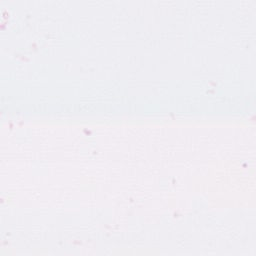

In [16]:
tmp

In [17]:
def calc_non_gray_ratio(image, intensity=0.8):
    im_gray = rgb2gray(image/255)
    im_gray_mask = (im_gray <= intensity)
    return (im_gray_mask.mean())

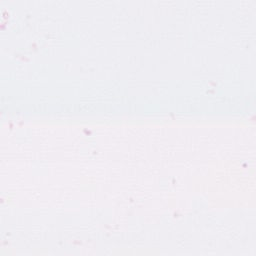

In [18]:
tmp

In [19]:
infos = []

In [20]:
for idx, row in tqdm(meta_df.iterrows()):
    img_id = row['img_id']
    data_type = row['type']
    img_file_paths = get_img_files_for_img_id(img_id, data_type)
    
    # total_mask_size_for_img = 0
    for img_file_path in img_file_paths:
        img_basename = os.path.basename(img_file_path)
        img_arr = np.asarray(Image.open(img_file_path))
        
        non_gray_ratio = calc_non_gray_ratio(img_arr, intensity=0.8)
        
        infos.append({
            'img_id': img_id, 
            'file_name': img_basename,
            'non_gray_ratio': non_gray_ratio,
            # 'total_mask_size_for_img': int(total_mask_size_for_img)
        })

21it [52:49, 97.78s/it] 


In [21]:
temp_df = pd.DataFrame(infos)

In [22]:
temp_df[temp_df['non_gray_ratio'] > 0.4].sort_values('non_gray_ratio').head()

,file_name,img_id,non_gray_ratio
634227,tumor_slide_031_split_30_104.png,031,0.400009
727709,tumor_slide_035_split_140_79.png,035,0.400009
1176628,tumor_slide_096_split_64_210.png,096,0.400009
1141333,tumor_slide_094_split_129_105.png,094,0.400024
49322,tumor_slide_001_split_428_119.png,001,0.400024


In [23]:
# temp_df.sort_values('non_gray_ratio')

In [26]:
# pd.__version__

In [35]:
sample_path = os.path.join(INPUT_DIRECTORY, 'train', 'slide', 'tumor_slide_096_split_64_210.png')

In [36]:
temp = Image.open(sample_path)

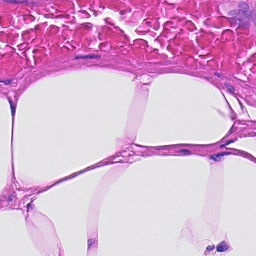

In [37]:
temp

In [38]:
temp_df.to_json('../../../data/zoom_1_256_256_partition/meta/zoom_1_256_256_partition_grayscale_info.json')

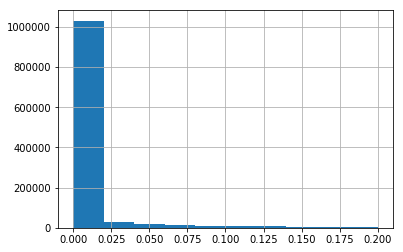

In [39]:
temp_df['non_gray_ratio'].hist(bins=10, range=[0, 0.2])

In [40]:
TOL = 1e-3

In [41]:
temp_df[temp_df['non_gray_ratio'] > TOL].shape

(327386, 3)